In [60]:
from torch import nn
import numpy as np
import pandas as pd
import pickle
import os
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torch
import random

In [85]:
with open(os.path.join("..","tensor_final"),"rb") as f:
    data_lc = pickle.load(f)
data_lc.shape

torch.Size([3000, 40])

In [54]:
class Autoencoder(nn.Module):
    
    def __init__(self):        
        super(type(self), self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(40,25),
            #nn.Sigmoid(),
            nn.Linear(25,10),
           #nn.Sigmoid(),
            nn.Linear(10,2),
           #nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,10),
            #nn.Sigmoid(),
            nn.Linear(10,25),
            #nn.Sigmoid(),
            nn.Linear(25,40),
            #nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [111]:
model = Autoencoder()
loader = DataLoader(data_lc.float().reshape(-1,40), batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()
for epoch in range(1000):
    loss_epoch = 0.0
    for data in loader:
        optimizer.zero_grad()
        prediction = model(data)
        loss = criterion(prediction, data)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    if epoch % 10 == 0:
        print(f"{epoch} {loss_epoch}")
        

0 43.82831287384033
10 42.98337435722351
20 41.998518109321594
30 40.52110195159912
40 38.451524913311005
50 36.088431656360626
60 33.898750364780426
70 32.02874559164047
80 30.404133439064026
90 29.053907811641693
100 27.992718815803528
110 27.16555118560791
120 26.540754199028015
130 26.03712373971939
140 25.672612726688385
150 25.38856703042984
160 25.187190771102905
170 25.027010828256607
180 24.91864413022995
190 24.84391713142395
200 24.793173044919968
210 24.753719925880432
220 24.732995480298996
230 24.717872619628906
240 24.69704383611679
250 24.702195286750793
260 24.69369611144066
270 24.69073823094368
280 24.698713809251785
290 24.685011953115463
300 24.682119697332382
310 24.68535751104355
320 24.682618468999863
330 24.68081983923912
340 24.68438571691513
350 24.686385333538055
360 24.68544015288353
370 24.683934718370438
380 24.682471185922623
390 24.685855954885483
400 24.682400345802307
410 24.6886183321476
420 24.685562252998352
430 24.68861010670662
440 24.69316038489

esto es para comparar original contra prediccion del autoencoder

(3000, 40) torch.Size([3000, 40])


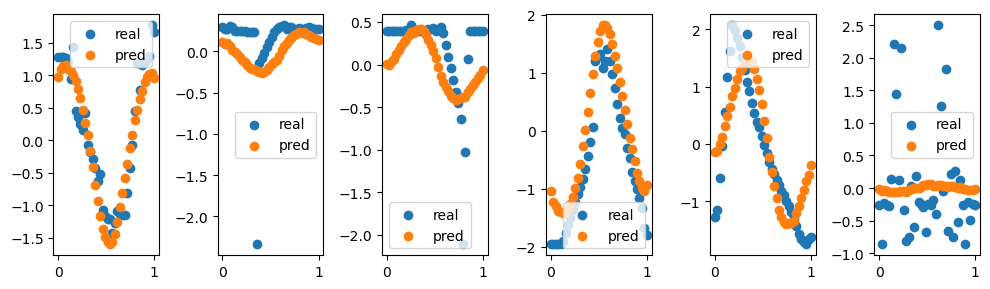

In [112]:
x = data_lc.float().reshape(-1, 40)
z = model(x).detach().numpy()
ax_x = np.linspace(0,1,40)
data_random = random.sample(range(0,3000),6)
fig,ax = plt.subplots(1,6,figsize=(10,3),tight_layout=True)
print(z.shape,data_lc.shape)
for real,pred,ax_ in zip(data_lc[data_random],z[data_random],ax):
    ax_.scatter(ax_x,real,label="real")
    ax_.scatter(ax_x,pred,label="pred")
    ax_.legend()

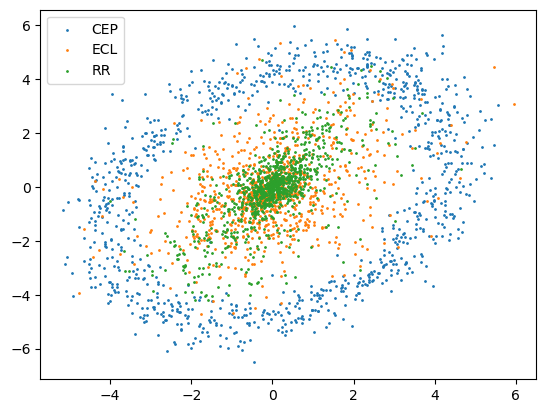

In [117]:
x = data_lc.float().reshape(-1, 40)
z = model.encode(x).detach().numpy()
fig,ax = plt.subplots()

ax.scatter(z[0:1000,0],z[0:1000,1],s=1,label="CEP")
ax.scatter(z[1000:2000,0],z[1000:2000,1],s=1,label="ECL")
ax.scatter(z[2000:3000,0],z[2000:3000,1],s=1,label="RR")
ax.legend()